In [0]:
import torch
import numpy as np
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import csv
import cv2
import os
from collections import defaultdict, OrderedDict
import pickle
from google.colab.patches import cv2_imshow
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_path = './drive/My Drive/DL/Assignment-1/'

In [0]:
import h5py
filename = drive_path+'classification_training_data.h5'

In [0]:
with h5py.File(filename, 'r') as f:
    feature1 = list(f.keys())[0]
    feature2 = list(f.keys())[1]
    data1 = list(f[feature1])
    data = np.array(data1)
    label = list(f[feature2])
    labels = np.array(label)

In [6]:
classes = 10

train_labels = labels[0:8000,:]
dev_labels = labels[8000:,:]
train_labels = train_labels.reshape(train_labels.shape[0])
dev_labels = dev_labels.reshape(dev_labels.shape[0])
train_labels = train_labels.astype('int')
dev_labels = dev_labels.astype('int')

training_data = data[0:8000,:]
val_data = data[8000:,:]

print(labels.shape, data.shape, train_labels.shape, dev_labels.shape, training_data.shape, val_data.shape)

training_data = training_data.reshape((training_data.shape[0], 3, 32, 32))
train_data = np.transpose(training_data, [0,2,3,1])
train_data = train_data.astype('int')
print(train_data.shape)

val_data = val_data.reshape((val_data.shape[0], 3, 32, 32))
dev_data = np.transpose(val_data, [0,2,3,1])
dev_data = dev_data.astype('int')
print(dev_data.shape)

(10000, 1) (10000, 3072) (8000,) (2000,) (8000, 3072) (2000, 3072)
(8000, 32, 32, 3)
(2000, 32, 32, 3)


In [0]:
train_data_count = np.zeros(10)
for c in range(classes):
    for l in train_labels:
        if l == c:
            train_data_count[c]+=1

print(train_data_count)

[817. 812. 765. 802. 825. 827. 776. 776. 788. 812.]


In [0]:
img_vis = np.zeros((10,10), int)
for c in range(classes):
    count = 0
    for i in range(train_data.shape[0]):
        if count == 10:
            break    
        elif train_labels[i] == c:
            img_vis[c][count] = i
            count += 1

print(img_vis)

[[ 12  18  22 104 113 125 131 143 150 159]
 [  0   3  13  24  34  46  56  60  75  76]
 [  9  11  17  20  32  49  84  87 112 115]
 [  7  54  57  58  66  73  78  86  95  97]
 [  6  23  27  28  33  36  65  67  71  77]
 [  2   4  14  44  51  53  69  91 105 114]
 [ 16  31  35  38  39  41  47  74  94  96]
 [  5  10  21  25  26  45  55  61  64  89]
 [  1   8  19  48  62  70  93 109 110 122]
 [ 15  29  30  37  40  42  43  50  52  59]]


In [0]:
def vis_img(mat):
    plt.figure(figsize=(20,8))
    for i, img in enumerate(mat, start=1):
        plt.subplot(2, 5, i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

class: 0


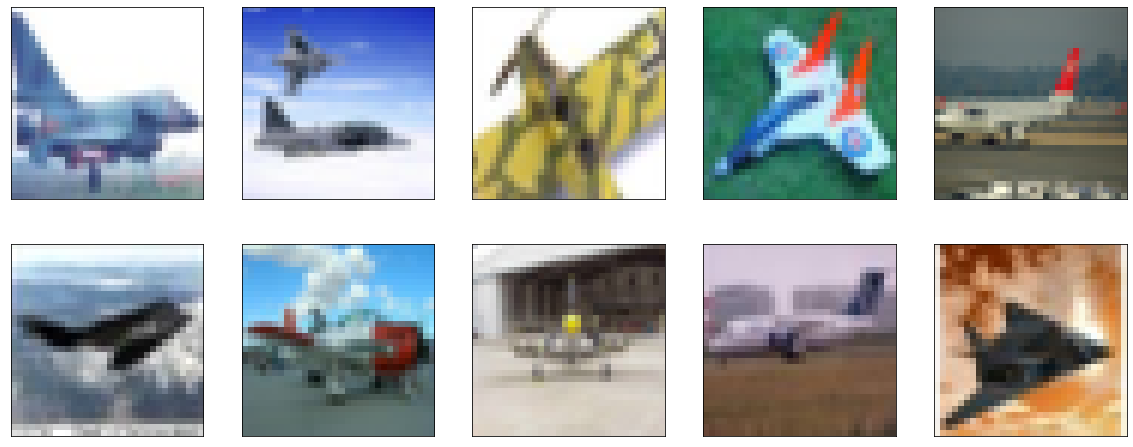

class: 1


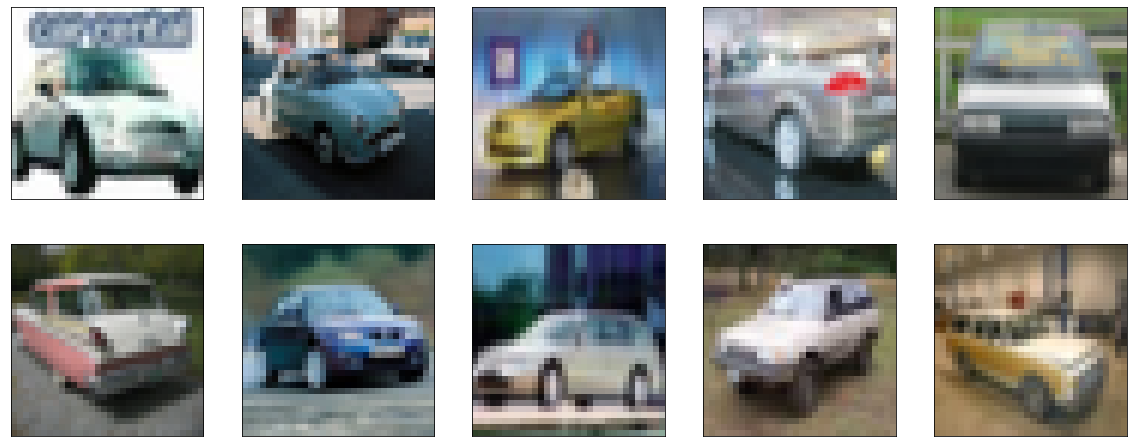

class: 2


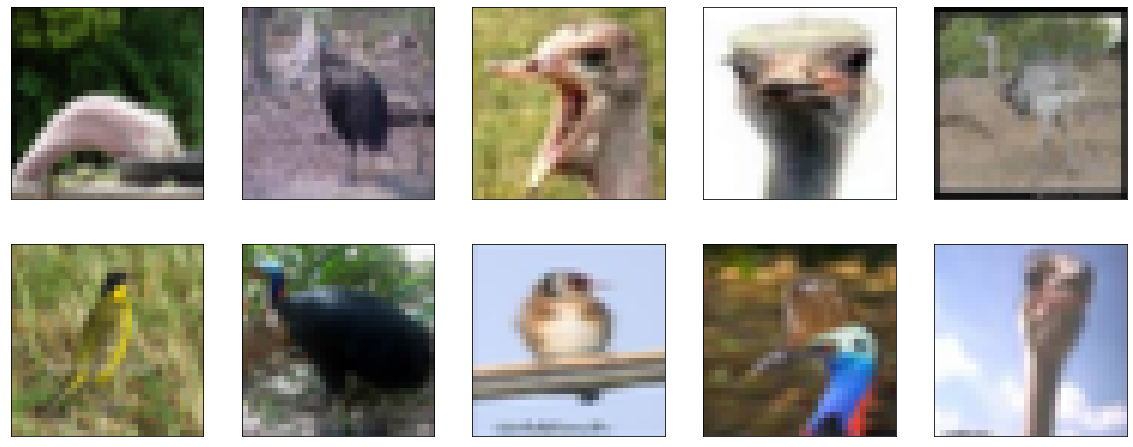

class: 3


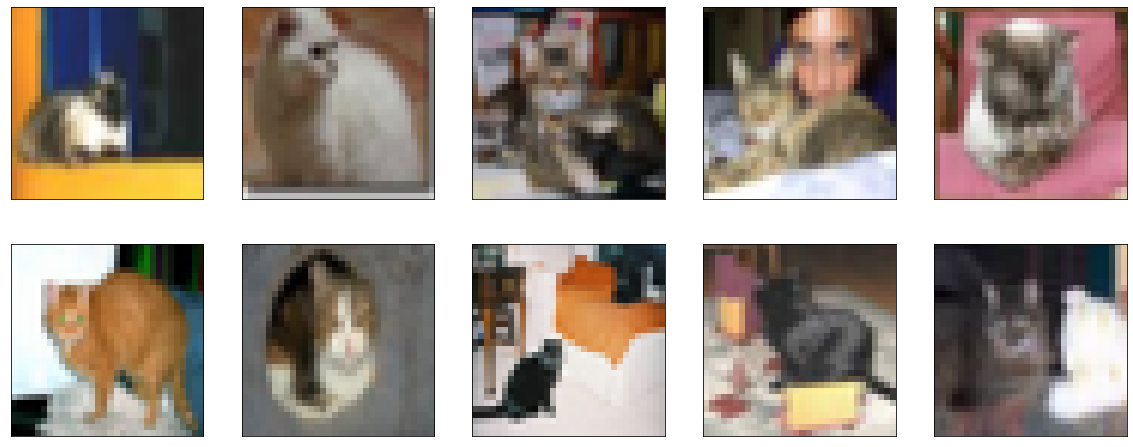

class: 4


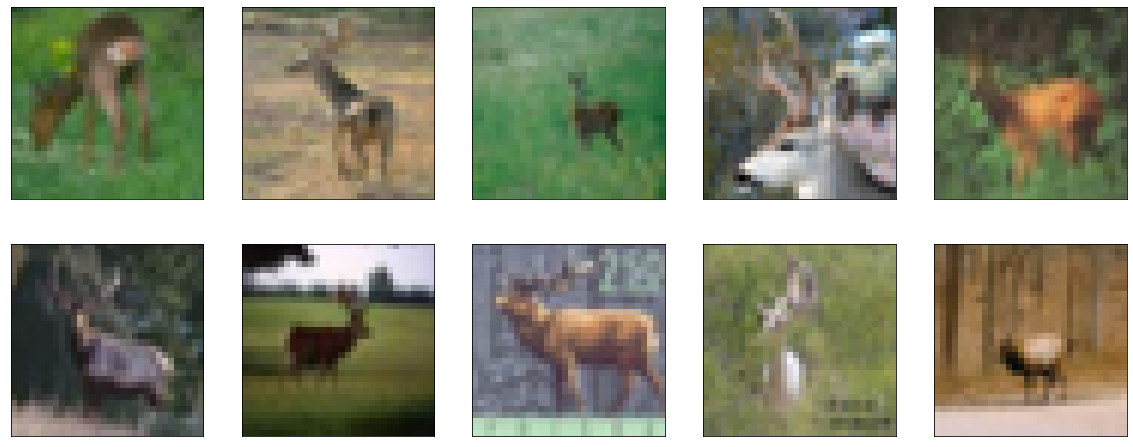

class: 5


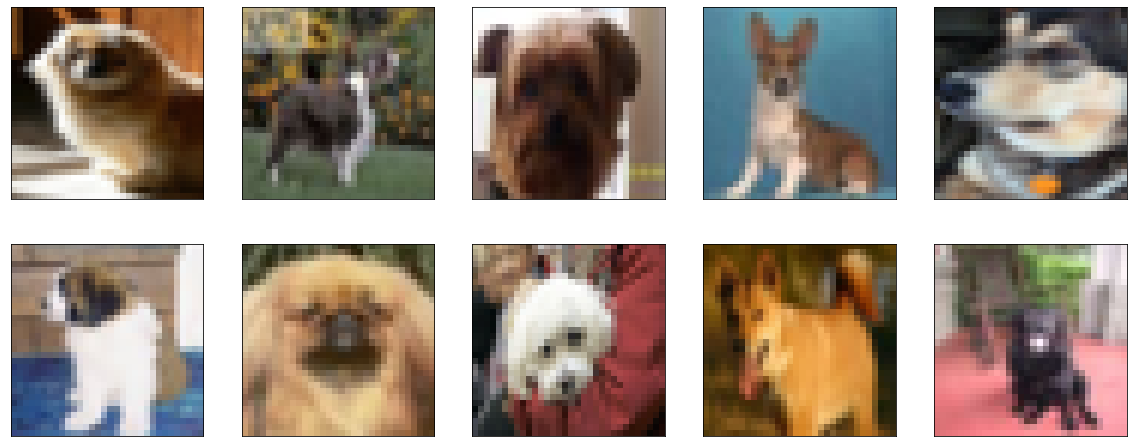

class: 6


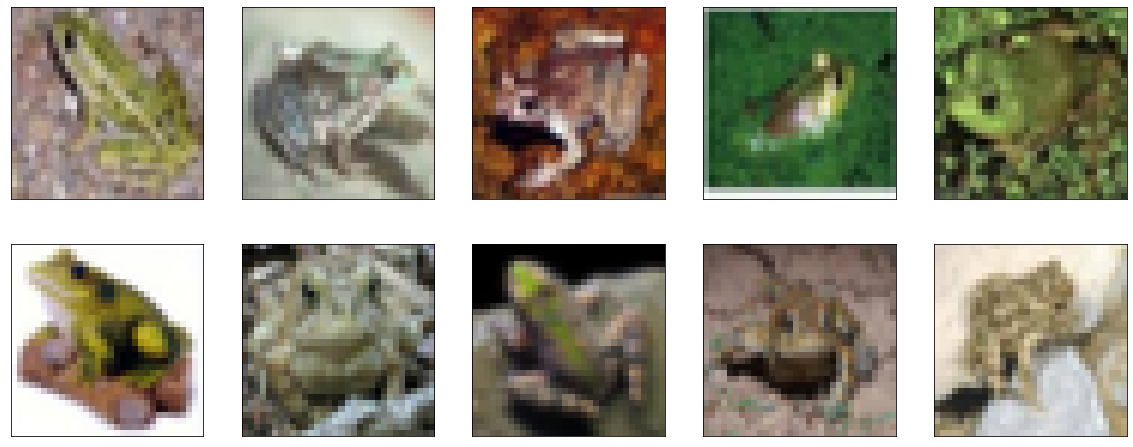

class: 7


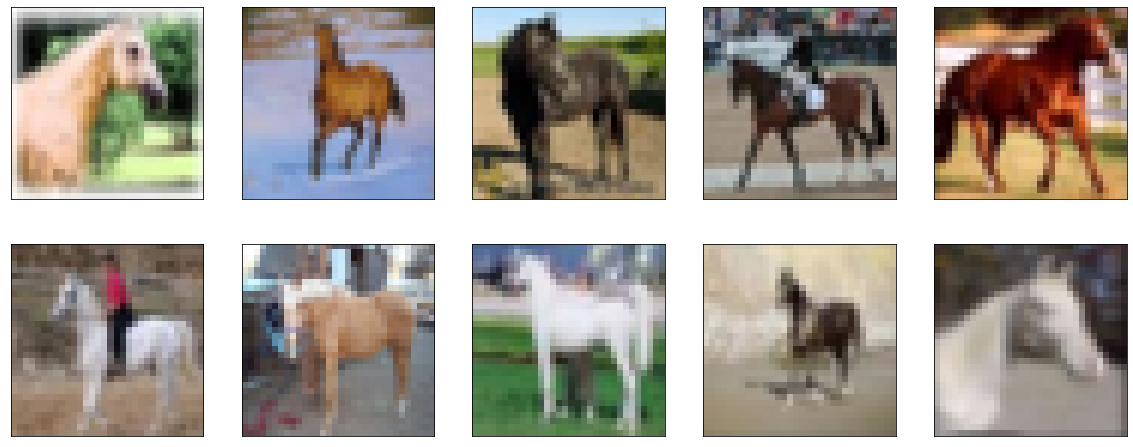

class: 8


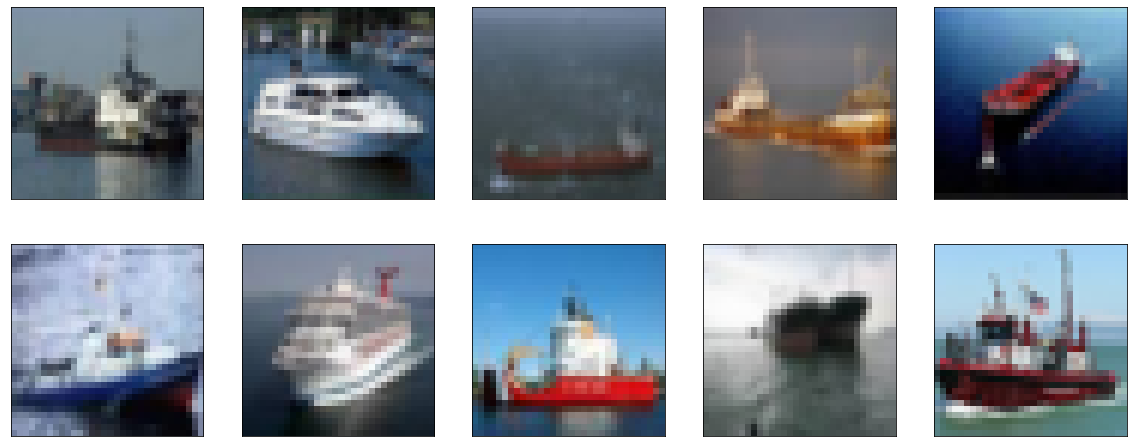

class: 9


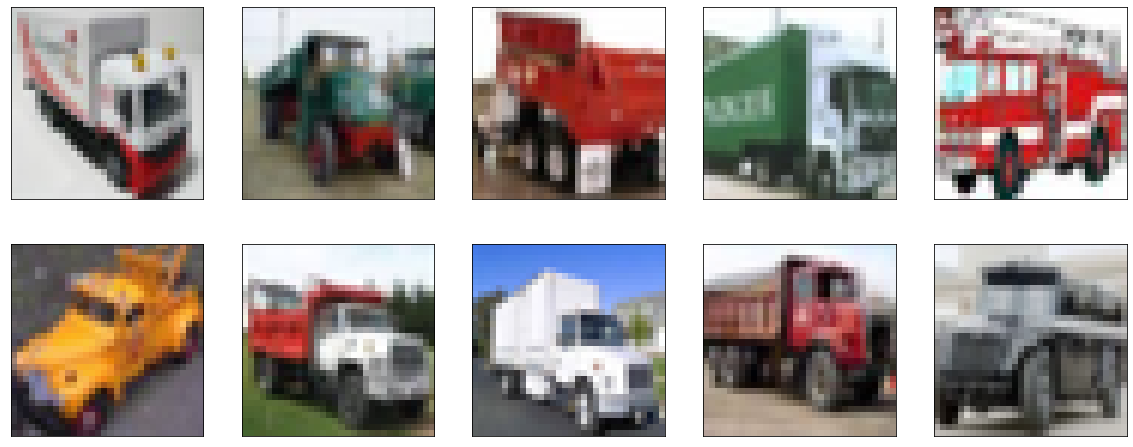

In [0]:
# for c in range(classes):
#     print('class:', c)
#     mat = np.zeros((10, 32, 32, 3), int)
#     for i in range(10):
#         mat[i] = train_data[img_vis[c][i]]
#     vis_img(mat)

In [0]:
class Dataset1(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        target = self.labels[index]
        data_val = self.list_IDs[index]
        return data_val,target

In [0]:
final_train_data = []
final_target_train = []
for i in range(len(training_data)):
    final_train_data.append(training_data[i])
    final_train_data.append(rotate(training_data[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(training_data[i]))
    final_train_data.append(np.flipud(training_data[i]))
    # final_train_data.append(random_noise(training_data[i],var=0.2**2))
    for j in range(4):
        final_target_train.append(train_labels[i])

final_train_data = np.array(final_train_data)
final_target_train = np.array(final_target_train)

In [9]:
print(len(final_train_data), len(final_target_train))

32000 32000


In [23]:
train_dataset = torch.FloatTensor(final_train_data.astype('float'))
# train_dataset = torch.FloatTensor(training_data.astype('float'))
valid_dataset = torch.FloatTensor(val_data.astype('float'))
# train_dataset = train_dataset / 255.0
# valid_dataset = valid_dataset / 255.0

train_l = torch.FloatTensor(final_target_train.astype('float'))
# train_l = torch.FloatTensor(train_labels.astype('float'))
valid_l = torch.FloatTensor(dev_labels.astype('float'))


device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    print('cuda')
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
training_set = Dataset1(train_dataset, train_l)
training_generator = DataLoader(training_set, batch_size=40, shuffle=True, **kwargs)

val_set = Dataset1(valid_dataset, valid_l)
val_generator = DataLoader(val_set, batch_size=20, shuffle=False, **kwargs)

cuda


In [0]:
# train_dataset = torch.FloatTensor(training_data.astype('float'))
# valid_dataset = torch.FloatTensor(val_data.astype('float'))
# train_l = torch.FloatTensor(train_labels.astype('float'))
# valid_l = torch.FloatTensor(dev_labels.astype('float'))

# train_data = torch.utils.data.TensorDataset(train_dataset, train_l)
# train_indices = np.arange(len(training_data))
# np.random.shuffle(train_indices.tolist())

# train_sample = SubsetRandomSampler(train_indices)
# training_generator = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=train_sample, num_workers=0)

# test_dataset = torch.utils.data.TensorDataset(valid_dataset, valid_l)
# val_generator = torch.utils.data.DataLoader(test_dataset)

In [0]:
class MyDropout(nn.Module):
    def __init__(self, p: float = 0.2):
        super(MyDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, " "but got {}".format(p))
        self.p = p

    def forward(self, X):
        if self.training:
            binomial = torch.distributions.binomial.Binomial(probs=1-self.p)
            return X * binomial.sample(X.size()).cuda() * (1.0/(1-self.p))
        return weight

In [0]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            MyDropout(p=0.3))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            MyDropout(p=0.3))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            MyDropout(p=0.3))
        
        self.fc1 = nn.Linear(64 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = MyDropout(p=0.3)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # print(x.size())

        x = x.view(x.size(0), -1)
        # x = x.view(-1, 64*4*4)
        x = self.fc1(x)
        # x = F.relu(x)
        x = self.dropout(F.relu(x))
        x = self.fc2(x)
        x = F.softmax(x)

        return x

In [0]:
def weights_init_uniform(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

def weights_init_zero(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.zeros_(m.weight)
        nn.init.zeros_(m.bias)

def weights_init_xavier(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

def weights_init_he(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, a=np.sqrt(5)) 
        if m.bias is not None: 
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight) 
            bound = 1 / np.sqrt(fan_in) 
            nn.init.uniform_(m.bias, -bound, bound)

def weights_init_constant(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.constant_(m.weight, 0.5)
        m.bias.data.fill_(0)

In [24]:
model = CNN().cuda()
# model.apply(weights_init_xavier)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): MyDropout()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): MyDropout()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): MyDropout()
  )
  (fc1): Linear(in_features=1024, out_features=100,

In [0]:
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)

In [26]:
training_epochs = 50
train_cost = np.zeros(training_epochs)
test_cost = np.zeros(training_epochs)
train_accu = np.zeros(training_epochs)
test_accu = np.zeros(training_epochs)
batch_size = 40
batch_size_test = 20
total_batch = len(train_dataset) // batch_size
total_batch_test = len(valid_dataset) // batch_size_test

print('Size of the training dataset is {}'.format(len(train_dataset)))
print('Size of the testing dataset is {}'.format(len(valid_dataset)))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('Total number of epochs is : {0:2.0f}'.format(training_epochs))

Size of the training dataset is 32000
Size of the testing dataset is 2000
Batch size is : 40
Total number of batches is : 800
Total number of epochs is : 50


In [0]:
def compute_accuracy(Y_target, hypothesis):
    Y_prediction = hypothesis.data.max(dim=1)[1]
    acc = 0
    for i in range(len(Y_target.data)):
        if Y_prediction.data[i] == Y_target.data[i]:
            acc += 1
    acc = acc / len(Y_prediction.data)
    return acc

In [28]:
grads = {}
for epoch in range(training_epochs):
    tr_ac = []
    tr_c = []
    weights_gradients = {}
    correct = 0

    for i, (batch_X, batch_Y) in enumerate(training_generator):
        X = Variable(batch_X).cuda().float()
        Y = Variable(batch_Y).cuda().long()
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()

        # for name, param in model.named_parameters():
        #     if name.split(".")[1] == "weight":
        #         p = param.grad.cpu()
        #         if name in weights_gradients:
        #             weights_gradients[name] += np.linalg.norm(p)
        #         else:
        #             weights_gradients[name] = np.linalg.norm(p)
        #     elif name.split(".")[1] != "bias" and name.split(".")[2] == "weight":
        #         p = param.grad.cpu()
        #         if name in weights_gradients:
        #             weights_gradients[name] += np.linalg.norm(p)
        #         else:
        #             weights_gradients[name] = np.linalg.norm(p)
            
        optimizer.step()
        # _, pred1 = torch.max(hypothesis, 1)
        # correct += (pred1==Y).sum().item()
        # tr_ac.append(correct/batch_size)
        tr_ac.append(compute_accuracy(Y, hypothesis))
        tr_c.append(cost.item())
    grads[epoch] = weights_gradients
        
    train_accu[epoch] = (np.sum(np.array(tr_ac)) / total_batch)
    train_cost[epoch] = (np.sum(np.array(tr_c)) / total_batch)
    
    with torch.no_grad():
        ac = []
        c = []
        correct = 0
        for i, (batch_X, batch_Y) in enumerate(val_generator):
            X = Variable(batch_X).cuda().float()
            Y = Variable(batch_Y).cuda().long()

            hypothesis = model(X)
            cost = criterion(hypothesis, Y)
            ac.append(compute_accuracy(Y, hypothesis))
            c.append(cost.item())
        
        test_accu[epoch] = (np.sum(np.array(ac)) / total_batch_test)
        test_cost[epoch] = (np.sum(np.array(c)) / total_batch_test)
        
        print("[Epoch: {:>4}], Training: averaged cost = {:>.9}, averaged accuracy = {:>.9}, Testing: averaged cost = {:>.9}, averaged accuracy = {:>.9}".format(epoch + 1, train_cost[epoch], train_accu[epoch], test_cost[epoch], test_accu[epoch]))

print('Learning Finished!')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch:    1], Training: averaged cost = 2.29989011, averaged accuracy = 0.107375, Testing: averaged cost = 2.29475109, averaged accuracy = 0.1155
[Epoch:    2], Training: averaged cost = 2.29032582, averaged accuracy = 0.13140625, Testing: averaged cost = 2.27399575, averaged accuracy = 0.157
[Epoch:    3], Training: averaged cost = 2.27085194, averaged accuracy = 0.16128125, Testing: averaged cost = 2.24455981, averaged accuracy = 0.1935
[Epoch:    4], Training: averaged cost = 2.24382874, averaged accuracy = 0.195875, Testing: averaged cost = 2.2193614, averaged accuracy = 0.2295
[Epoch:    5], Training: averaged cost = 2.22477678, averaged accuracy = 0.21684375, Testing: averaged cost = 2.19403911, averaged accuracy = 0.2575
[Epoch:    6], Training: averaged cost = 2.20771445, averaged accuracy = 0.237875, Testing: averaged cost = 2.17529028, averaged accuracy = 0.277
[Epoch:    7], Training: averaged cost = 2.19376613, averaged accuracy = 0.25615625, Testing: averaged cost = 2.176

In [29]:
torch.save(model, drive_path+'q1/q1_block3_relu_da4_model')
np.save(drive_path+'q1/q1_block3_relu_da4_train_accu', train_accu)
np.save(drive_path+'q1/q1_block3_relu_da4_test_accu', test_accu)
np.save(drive_path+'q1/q1_block3_relu_da4_train_cost', train_cost)
np.save(drive_path+'q1/q1_block3_relu_da4_test_cost', test_cost)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyDropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model1 = torch.load(drive_path+'q1/q1_block1_tanh_model')

In [0]:
print(model1)

In [0]:
def plot(arr1, arr2, x, title='Accuracy vs Epoch', type='Accuracy'):
    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(x, arr1, label = 'Training '+ type)
    plt.plot(x, arr2, label = 'Validation ' + type)
        
    plt.xlabel('Epoch')
    plt.ylabel(type)
    plt.legend()
    
    plt.title(title)
    plt.show()

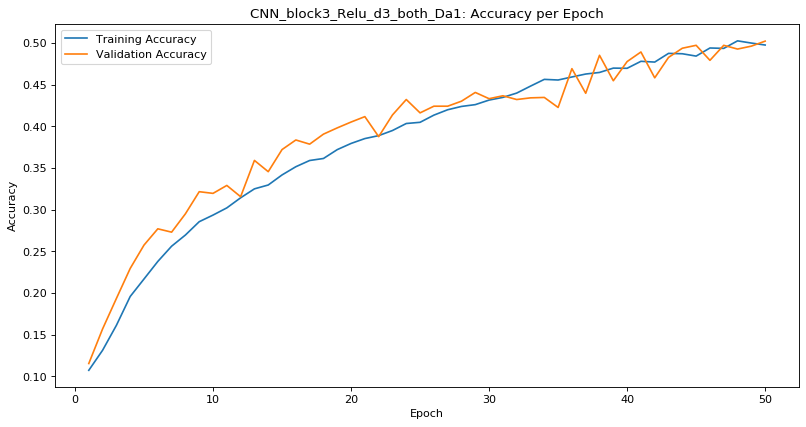

In [31]:
plot(train_accu, test_accu, list(range(1, training_epochs + 1)), title='CNN_block3_Relu_d3_both_Da1: Accuracy per Epoch', type='Accuracy')

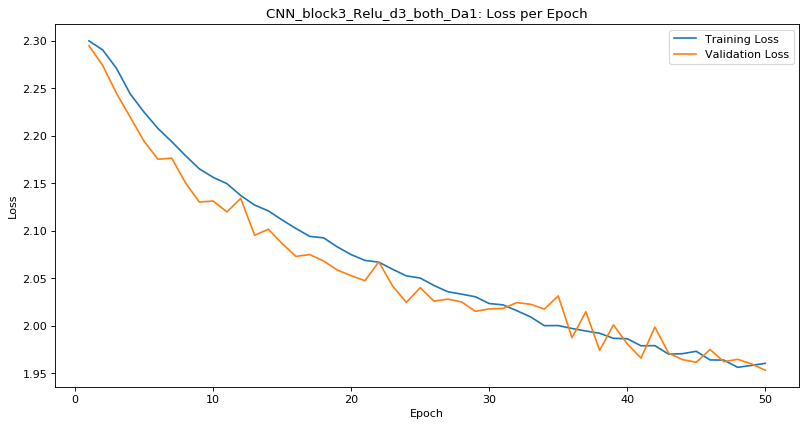

In [32]:
plot(train_cost, test_cost, list(range(1, training_epochs + 1)), title='CNN_block3_Relu_d3_both_Da1: Loss per Epoch', type='Loss')

In [0]:
def test_model(model, testloader, criterion):
    was_training = model.training
    model.eval()
    
    running_corrects = 0
    loss = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            _, preds = torch.max(logits, 1)
            
            test_loss = criterion(logits, labels)

            running_corrects += torch.sum(preds == labels.data)
            loss += test_loss.item() * inputs.size(0)

    accuracy = (running_corrects.double() / len(testset)).cpu().numpy()
    loss /= len(testset)

    model.train(mode=was_training)

    return accuracy, loss

In [0]:
def model_test(model, testloader, criterion, batch_no):
    with torch.no_grad():
        ac = []
        c = []
        for i, (batch_X, batch_Y) in enumerate(testloader):
            X = Variable(batch_X).cuda().float()
            Y = Variable(batch_Y).cuda().long()

            hypothesis = model(X)
            cost = criterion(hypothesis, Y)
            ac.append(compute_accuracy(Y, hypothesis))
            c.append(cost.item())
        
        test_accu = (np.sum(np.array(ac)) / batch_no)
        test_cost = (np.sum(np.array(c)) / batch_no)
        
        print("Cost = {:>.9}, Accuracy = {:>.9}".format(test_cost, test_accu))

In [0]:
model1 = torch.load(drive_path+'q1/q1_block3_relu_da4_model')

In [39]:
import h5py
drive_path = './drive/My Drive/DL/Assignment-1/'
filename = drive_path+'classification_training_data.h5'

with h5py.File(filename, 'r') as f:
    feature1 = list(f.keys())[0]
    feature2 = list(f.keys())[1]
    data1 = list(f[feature1])
    data = np.array(data1)
    label = list(f[feature2])
    labels = np.array(label)

classes = 10

labels = labels.reshape(labels.shape[0])
labels = labels.astype('int')
data = data.reshape((data.shape[0], 3, 32, 32))
dataset = torch.FloatTensor(data.astype('float'))
label = torch.FloatTensor(labels.astype('float'))
final_dataset = Dataset1(dataset, label)

testloader = DataLoader(final_dataset, batch_size=20, shuffle=False)
batch_no = data.shape[0] / 20
# print(batch_no)

500.0


In [43]:
model_test(model1, testloader, torch.nn.CrossEntropyLoss(), batch_no)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Cost = 1.89405985, Accuracy = 0.5637
